In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt


Data Loading

In [15]:
# === Load Data ===
df = pd.read_csv("traj.csv")  # or use your DataFrame directly

X = torch.tensor(df.iloc[30000:70000, :5].values, dtype=torch.float32)
y = torch.tensor(df.iloc[30000:70000, 5:].values, dtype=torch.float32)

dataset = TensorDataset(X, y)
train_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

Model Definition

In [16]:

# === Behavioural Model ===
class Behavioural(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Training Process

In [18]:
# === Training Function ===
lr = 0.006
num_epochs = 50
model = Behavioural(input_dim=5, hidden_dim=32, output_dim=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss = criterion(pred, yb)
            epoch_val_loss += val_loss.item()
    val_losses.append(epoch_val_loss / len(val_loader))

# torch.save(model.state_dict(), 'Behavioural_model_2.pth')

In [21]:
val_losses

[1.3250459129994852e-05,
 7.204975866989116e-06,
 1.9394979962089565e-05,
 5.820106020109961e-06,
 1.2690819897397886e-05,
 8.897267924476182e-06,
 1.8693374674512597e-06,
 7.308315303816926e-06,
 1.6387951911019628e-05,
 4.055238730143173e-06,
 2.5030877704921296e-06,
 2.526296576979803e-06,
 6.112797456353291e-07,
 1.1853261773921986e-07,
 6.963442977848899e-07,
 3.285036629677052e-07,
 3.757863702276154e-07,
 6.681788343030348e-07,
 7.849300589555242e-08,
 1.0677846162707283e-06,
 7.250196654240426e-07,
 7.327008129323076e-07,
 3.034445738649083e-07,
 1.7954349610954523e-05,
 1.604138423317636e-07,
 7.152211494485528e-07,
 1.4498232448545423e-07,
 3.735331143161602e-07,
 2.4444526318347926e-07,
 4.5312681354516826e-07,
 1.761946032729611e-07,
 5.121801345558197e-06,
 8.992236195695113e-08,
 1.1654569713073215e-07,
 2.217717791609175e-07,
 2.2916166788036209e-07,
 1.2917747738356411e-06,
 6.603108054150653e-07,
 5.576904698614271e-08,
 3.427155452300212e-08,
 9.566641257663378e-09,
 

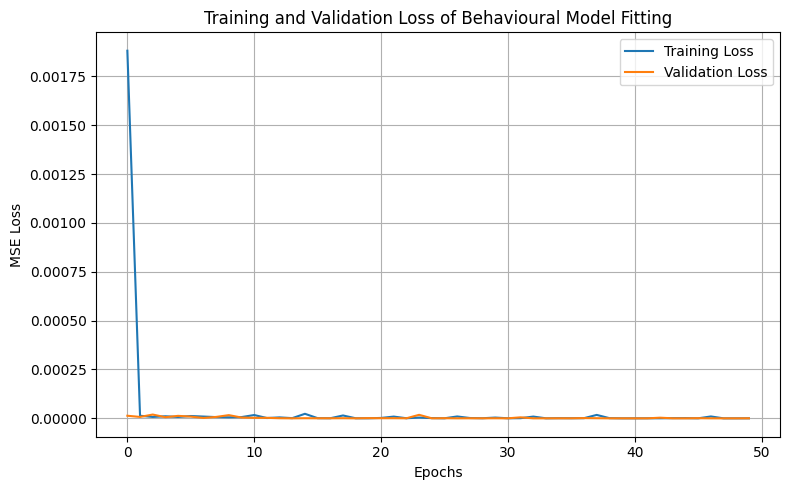

In [19]:

# === Plotting ===
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss of Behavioural Model Fitting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
plt.savefig('Behavioural_model_loss.png')

<Figure size 640x480 with 0 Axes>

Grid Search Result

In [ ]:
df_result = pd.read_csv("grid_search_results.csv")

In [10]:
def r2_score(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

In [17]:
# model.eval()
all_preds, all_targets = [], []
device = "cuda"
with torch.no_grad():
    for xb, yb in val_loader:
        # xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        all_preds.append(pred)
        all_targets.append(yb)

# Concatenate all predictions and targets
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
r2 = r2_score(all_preds, all_targets).item()
r2


1.0